In [1]:
import pandas as pd
import os
import json
import numpy as np

### WRITE UP ###

<span style="font-size:18px">Started with 592 ppts
    

<span style="font-size:18px">Failed at least one attention checks: 170 ppts

<span style="font-size:18px">Left with: 422 ppts
    
<span style="font-size:18px">After exclusion criteria is applied to the WM task, we are left with 271 participants. 

<span style="font-size:18px">There will be some participants who did the WM task but did not complete questionnaires. Once I merge questionnaire and task datasets, we will drop those participants which will further reduce our sample size. And indeed 9 did not complete, so we are left with 262 after all the exclusion criteria and cleaning.
    
<span style="font-size:18px">Exclusion criteria for WM task: If RT is longer than 3 seconds, RT column value is empty and accuracy is automatically counted as incorrect. If average accuracy of a participant is lower than 40%, they are dropped. If they completed less than 2/3 trials, they are removed. No other criteria. I might want to add some.
    
<span style="font-size:18px">I initially was removing all the participants who failed at least one attention check in questionnaires. However, exploratory analysis revealed that one attention check might have been ambiguous and failing it might not be a good index of inattention. See below the details of multiple exploratory analyses I have conducted. So, I decided to only removed participants who failed > 1 attention checks. The ambiguous attention check was osivq-catch-1: "Elephants are larger than dogs".
    
<span style="font-size:18px">Failed more than one attention checks: 86 ppts, so we would gain 170-86=84 participants

<span style="font-size:18px">I am now thinking that maybe actually I should further remove those who failed only one attention check but that attention check was not the ambiguous one. Might be a more fair approach. In this case, we would further remove 29 participants. And the final dataset would have 262-29=233 ppts

<!-- Failed at least one attention checks: 170 ppts

Left with: 422 ppts -->

In [2]:
# Path to participant questionnaire JSON files
directory_path_questionnaires = 'individual_questionnaires'

In [7]:
# Function to combine questionnaire JSON files and convert it to csv

def process_json_files(directory_path, output_csv):
    """Process all JSON files in the directory, convert them to pandas DataFrames, and combine into one CSV file."""
    combined_df = pd.DataFrame()  # Initialize an empty DataFrame to store combined data

    # Iterate over each file in the directory
    for file_name in os.listdir(directory_path_questionnaires):
        if file_name.endswith('.json'):
            file_path = os.path.join(directory_path, file_name)
            # Load the JSON file into a DataFrame from the nested 'filedata' key
            try:
                data_frame = pd.read_json(file_path)
                # Extract the array of dictionaries associated with the 'filedata' key
                df = pd.DataFrame(data_frame['filedata'].tolist())
                # Append the dataframe to the combined dataframe
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except ValueError as e:
                print(f"Error reading {file_name}: {e}")

    # Once all files are processed, write the combined dataframe to a CSV
    if not combined_df.empty:
        combined_df.to_csv(output_csv, index=False)
    else:
        print("No data to write.")

# Path to the combined CSV file
output_csv_questionnaires = 'wm_combined_questionnaires.csv'

# Process the JSON files
process_json_files(directory_path_questionnaires, output_csv_questionnaires)

In [4]:
# Read the CSV file into a dataframe
df_questionnaires = pd.read_csv('pilot_TOTAL_merged_questionnaires.csv')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_25034/2427603714.py:2: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df_questionnaires = pd.read_csv('pilot_TOTAL_merged_questionnaires.csv')


In [5]:
# Convert vviq responses to numbers
def update_response(value):
    # Check each condition and update the response accordingly
    if 'No image' in value:
        return 0
    elif 'Dim' in value:
        return 1
    elif 'Moderately' in value:
        return 2
    elif 'reasonably' in value:
        return 3
    elif 'Perfectly' in value:
        return 4
    else:
        return value  # Return the original value if none of the conditions are met


# Apply the function to the 'response' column
df_questionnaires['response'] = df_questionnaires['response'].apply(update_response)

KeyError: 'response'

In [10]:
# Add 1 to each response in questionnaires as the responses are indexed from 0
# Convert 'response' column to numeric, coercing errors to NaN (if there are non-numeric strings)
df_questionnaires['response'] = pd.to_numeric(df_questionnaires['response'], errors='coerce')

# Add 1 to each numeric value in the 'response' column
df_questionnaires['response'] = df_questionnaires['response'] + 1

# Rename one of the osivq_catch trials because now I have duplicate names
# Check if the 'item' column contains the word 'Elephants'
mask = df_questionnaires['item'].str.contains('Elephants', na=False)

# Update the 'item_id' column where the mask is True
df_questionnaires.loc[mask, 'item_id'] = 'osivq-catch-1'

In [11]:
# Recode Recode irq and osivq items:
# irq-verbal-10: I rarely vocalize thoughts in my mind
# irq-manipulation-5: I find it difficult to imagine how a three-dimensional geometric figure would exactly look like when rotated
# osviq-spatial-14: I find it difficult to imagine how a three-dimensional geometric figure would exactly look like when rotated
# osviq-verbal-1: I have difficulty expressing myself in writing
# osviq-verbal-4: Essay writing is difficult for me and I do not enjoy doing it at all
# osviq-verbal-15: I sometimes have a problem expressing exactly what I want to say

# Define the item IDs to look for
item_ids = ['irq-verbal-10', 'irq-manipulation-5', 'osviq-spatial-14', 'osviq-verbal-1', 'osviq-verbal-4', 'osviq-verbal-15']

# Update the response column where item_id is in the list
df_questionnaires.loc[df_questionnaires['item_id'].isin(item_ids), 'response'] = 6 - df_questionnaires['response']

# filtered_rows = df_questionnaires[df_questionnaires['item_id'].isin(item_ids)]
# filtered_rows

In [12]:
# Remove empty (irrelevant) columns from questionnaires dataframe
columns_to_remove = ['trial_index', 'sona_id', 'item', 'internal_node_id', 'category', 'questionnaire']
df_questionnaires.drop(columns_to_remove, axis=1, inplace=True)

In [13]:
# Before pivoting, get the max time elapsed per subject (assuming larger values = later in experiment)
time_data = df_questionnaires.groupby('subject_id')['time_elapsed'].max().reset_index()

In [14]:
# Pivot the DataFrame
df_reformatted = df_questionnaires.pivot(index='subject_id', columns='item_id', values='response')

# Reset the index to convert 'subject' from an index to a column
df_reformatted.reset_index(inplace=True)

# Remove the index name to clean up the DataFrame presentation
df_reformatted.columns.name = None
df_questionnaires = df_reformatted

In [15]:
# Then after pivoting, merge this data back
df_questionnaires = pd.merge(df_reformatted, time_data, on='subject_id', how='left')

In [16]:
# Function to determine questionnaire attention accuracy
def calculate_attention(row):
    if (row['osivq-catch-1'] != 5) or (row['osivq-catch-2'] != 1) or (row['irq-catch-1'] != 1):
        return 0
    else:
        return 1

# Apply function across rows
df_questionnaires['attention_accuracy_questionnaires'] = df_questionnaires.apply(calculate_attention, axis=1)

In [18]:
# Filter rows where attention_accuracy_questionnaires is 0
filtered_df = df_questionnaires[df_questionnaires['attention_accuracy_questionnaires'] == 0]

# Count unique subjects with attention accuracy of 0
unique_subjects_with_accuracy_0 = filtered_df['subject_id'].nunique()
# Print the count of unique subjects
print(f"Number of unique subjects with questionnaire accuracy = 0: {unique_subjects_with_accuracy_0}")

Number of unique subjects with questionnaire accuracy = 0: 170


In [19]:
# # Remove participants who failed attention checks
# df_questionnaires = df_questionnaires[df_questionnaires['attention_accuracy_questionnaires'] != 0]

In [20]:
# Filter columns that contain 'vviq' in their name
vviq_columns = df_questionnaires.filter(like='vviq').columns

# Sum these columns row-wise and create a new column 'vviq_sum'
df_questionnaires['vviq_sum'] = df_questionnaires[vviq_columns].sum(axis=1)
mean_vviq_sum = df_questionnaires['vviq_sum'].mean()
std_vviq_sum = df_questionnaires['vviq_sum'].std()

# Calculate z-scores for 'vviq_sum'
df_questionnaires['vviq_z'] = (df_questionnaires['vviq_sum'] - mean_vviq_sum) / std_vviq_sum

In [21]:
# Function to calculate the mean for specific pattern
def calculate_means(df, pattern):
    filtered_cols = df.filter(regex=pattern)
    return filtered_cols.mean(axis=1, skipna=True)

# Calculate means based on column name patterns
df_questionnaires['osivq_verbal_mean'] = calculate_means(df_questionnaires, 'osviq-verbal')
df_questionnaires['osivq_visual_mean'] = calculate_means(df_questionnaires, 'osviq-object')
df_questionnaires['osivq_spatial_mean'] = calculate_means(df_questionnaires, 'osviq-spatial')
df_questionnaires['irq_verbal_mean'] = calculate_means(df_questionnaires, 'irq-verbal')
df_questionnaires['irq_visual_mean'] = calculate_means(df_questionnaires, 'irq-visual')

# Function to calculate z-scores
def calculate_z_scores(series):
    return (series - series.mean()) / series.std()

# Calculate z-scores for each new mean column
df_questionnaires['z_osivq_verbal_mean'] = calculate_z_scores(df_questionnaires['osivq_verbal_mean'])
df_questionnaires['z_osivq_visual_mean'] = calculate_z_scores(df_questionnaires['osivq_visual_mean'])
df_questionnaires['z_osivq_spatial_mean'] = calculate_z_scores(df_questionnaires['osivq_spatial_mean'])
df_questionnaires['z_irq_verbal_mean'] = calculate_z_scores(df_questionnaires['irq_verbal_mean'])
df_questionnaires['z_irq_visual_mean'] = calculate_z_scores(df_questionnaires['irq_visual_mean'])

In [22]:
# Create a function to count how many attention checks each participant failed
def count_failed_checks(row):
    failed_count = 0
    if row['osivq-catch-1'] != 5:
        failed_count += 1
    if row['osivq-catch-2'] != 1:
        failed_count += 1
    if row['irq-catch-1'] != 1:
        failed_count += 1
    return failed_count

# Apply the function to create a new column
df_questionnaires['failed_check_count'] = df_questionnaires.apply(count_failed_checks, axis=1)

# Get distribution of failed checks
failed_checks_distribution = df_questionnaires['failed_check_count'].value_counts().sort_index()
print("Distribution of failed attention checks:")
print(failed_checks_distribution)
print(f"Percentage with 0 failed: {100 * failed_checks_distribution[0] / len(df_questionnaires):.2f}%")
print(f"Percentage with 1 failed: {100 * failed_checks_distribution.get(1, 0) / len(df_questionnaires):.2f}%")
print(f"Percentage with 2 failed: {100 * failed_checks_distribution.get(2, 0) / len(df_questionnaires):.2f}%")
print(f"Percentage with 3 failed: {100 * failed_checks_distribution.get(3, 0) / len(df_questionnaires):.2f}%")

# Create groups based on number of failed checks
df_pass_all = df_questionnaires[df_questionnaires['failed_check_count'] == 0]
df_fail_one = df_questionnaires[df_questionnaires['failed_check_count'] == 1]
df_fail_multiple = df_questionnaires[df_questionnaires['failed_check_count'] > 1]

# Compare key metrics across these groups
print("\nComparison of key metrics across groups:")
metrics = ['vviq_sum', 'osivq_verbal_mean', 'osivq_visual_mean', 'irq_visual_mean']

for metric in metrics:
    print(f"\n{metric}:")
    print(f"Pass all checks: Mean = {df_pass_all[metric].mean():.2f}, SD = {df_pass_all[metric].std():.2f}")
    if len(df_fail_one) > 0:
        print(f"Fail one check: Mean = {df_fail_one[metric].mean():.2f}, SD = {df_fail_one[metric].std():.2f}")
    if len(df_fail_multiple) > 0:
        print(f"Fail multiple checks: Mean = {df_fail_multiple[metric].mean():.2f}, SD = {df_fail_multiple[metric].std():.2f}")

# Check for specific response patterns that might indicate inattention
def check_response_pattern(df, group_name):
    print(f"\nResponse patterns for: {group_name}")
    
    # Check for straight-lining (same response for all items)
    for subject in df['subject_id'].unique():
        subject_data = df[df['subject_id'] == subject]
        
        # Get all response columns (excluding metadata and calculated fields)
        response_cols = [col for col in subject_data.columns if any(x in col for x in ['vviq', 'osivq', 'irq']) 
                         and not any(x in col for x in ['mean', 'sum', 'z_', 'attention', 'failed'])]
        
        # Check for consistent responses
        responses = subject_data[response_cols].values.flatten()
        responses = responses[~np.isnan(responses)]  # Remove NaN values
        
        unique_responses = np.unique(responses)
        if len(unique_responses) <= 2:  # If only using 1-2 response options
            print(f"Subject {subject} shows limited response variation (only uses {len(unique_responses)} response options)")
            print(f"Response values used: {unique_responses}")

# Check response patterns for each group
check_response_pattern(df_fail_one, "Participants who failed 1 check")
check_response_pattern(df_fail_multiple, "Participants who failed 2+ checks")

# Optional: Visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization for VVIQ scores across groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='failed_check_count', y='vviq_sum', data=df_questionnaires)
plt.title('VVIQ Score Distribution by Number of Failed Attention Checks')
plt.xlabel('Number of Failed Attention Checks')
plt.ylabel('VVIQ Sum Score')
plt.show()

Distribution of failed attention checks:
failed_check_count
0    422
1     84
2     39
3     47
Name: count, dtype: int64
Percentage with 0 failed: 71.28%
Percentage with 1 failed: 14.19%
Percentage with 2 failed: 6.59%
Percentage with 3 failed: 7.94%

Comparison of key metrics across groups:

vviq_sum:
Pass all checks: Mean = 56.64, SD = 13.26
Fail one check: Mean = 56.39, SD = 13.04
Fail multiple checks: Mean = 50.69, SD = 14.85

osivq_verbal_mean:
Pass all checks: Mean = 3.00, SD = 0.47
Fail one check: Mean = 2.99, SD = 0.42
Fail multiple checks: Mean = 3.08, SD = 0.36

osivq_visual_mean:
Pass all checks: Mean = 3.26, SD = 0.65
Fail one check: Mean = 3.24, SD = 0.61
Fail multiple checks: Mean = 3.26, SD = 0.50

irq_visual_mean:
Pass all checks: Mean = 3.54, SD = 0.69
Fail one check: Mean = 3.35, SD = 0.65
Fail multiple checks: Mean = 3.31, SD = 0.57

Response patterns for: Participants who failed 1 check


NameError: name 'np' is not defined

In [132]:
# Count failures for each specific attention check
osivq_catch1_failures = sum(df_questionnaires['osivq-catch-1'] != 5)
osivq_catch2_failures = sum(df_questionnaires['osivq-catch-2'] != 1)
irq_catch1_failures = sum(df_questionnaires['irq-catch-1'] != 1)

# Print the results
print("\nAttention check failure analysis:")
print(f"osivq-catch-1 (should be 5): {osivq_catch1_failures} failures ({osivq_catch1_failures/len(df_questionnaires)*100:.2f}%)")
print(f"osivq-catch-2 (should be 1): {osivq_catch2_failures} failures ({osivq_catch2_failures/len(df_questionnaires)*100:.2f}%)")
print(f"irq-catch-1 (should be 1): {irq_catch1_failures} failures ({irq_catch1_failures/len(df_questionnaires)*100:.2f}%)")

# For participants who failed exactly one check, see which check they failed
if len(df_fail_one) > 0:
    osivq_catch1_only = sum((df_fail_one['osivq-catch-1'] != 5) & (df_fail_one['failed_check_count'] == 1))
    osivq_catch2_only = sum((df_fail_one['osivq-catch-2'] != 1) & (df_fail_one['failed_check_count'] == 1))
    irq_catch1_only = sum((b)
    
    print("\nFor participants who failed exactly one check:")
    print(f"osivq-catch-1 only: {osivq_catch1_only} participants ({osivq_catch1_only/len(df_fail_one)*100:.2f}%)")
    print(f"osivq-catch-2 only: {osivq_catch2_only} participants ({osivq_catch2_only/len(df_fail_one)*100:.2f}%)")
    print(f"irq-catch-1 only: {irq_catch1_only} participants ({irq_catch1_only/len(df_fail_one)*100:.2f}%)")


Attention check failure analysis:
osivq-catch-1 (should be 5): 125 failures (21.11%)
osivq-catch-2 (should be 1): 82 failures (13.85%)
irq-catch-1 (should be 1): 96 failures (16.22%)

For participants who failed exactly one check:
osivq-catch-1 only: 55 participants (65.48%)
osivq-catch-2 only: 9 participants (10.71%)
irq-catch-1 only: 20 participants (23.81%)



Order effect analysis:
Correlation between time elapsed and number of checks passed: 0.07502921147282708

Average time elapsed by number of checks passed:
                       mean           std  count
checks_passed                                   
0              3.311514e+05  4.655517e+05     47
1              6.344899e+05  1.495214e+06     39
2              9.586182e+05  1.865234e+06     84
3              1.793429e+06  7.772420e+06    422


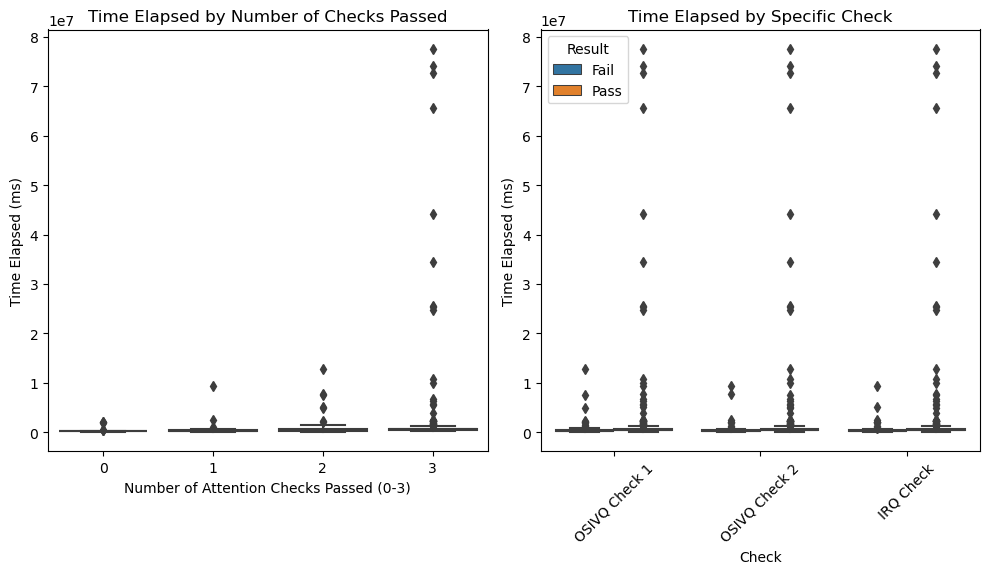


Average pass rate by time quartile:
               osivq_catch1_pass  osivq_catch2_pass  irq_catch1_pass  \
time_quartile                                                          
Q1                      0.445946           0.608108         0.540541   
Q2                      0.898649           0.939189         0.925676   
Q3                      0.925676           0.959459         0.966216   
Q4                      0.885135           0.939189         0.918919   

               checks_passed  
time_quartile                 
Q1                  1.594595  
Q2                  2.763514  
Q3                  2.851351  
Q4                  2.743243  


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_88481/3001646582.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_performance = attention_time_df.groupby('time_quartile')[


<Figure size 1000x600 with 0 Axes>

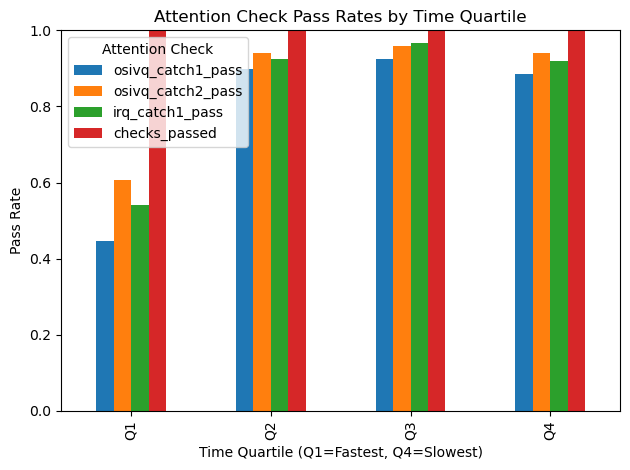

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First, see if time_elapsed is available in your original data
if 'time_elapsed' in df_questionnaires.columns:
    # Create a copy of the data with relevant columns for analysis
    attention_time_df = df_questionnaires[['subject_id', 'time_elapsed', 
                                                   'osivq-catch-1', 'osivq-catch-2', 'irq-catch-1']].copy()
    
    # Add columns indicating pass/fail for each check
    attention_time_df['osivq_catch1_pass'] = (attention_time_df['osivq-catch-1'] == 5).astype(int)
    attention_time_df['osivq_catch2_pass'] = (attention_time_df['osivq-catch-2'] == 1).astype(int)
    attention_time_df['irq_catch1_pass'] = (attention_time_df['irq-catch-1'] == 1).astype(int)
    
    # Calculate total passing (0-3)
    attention_time_df['checks_passed'] = (attention_time_df['osivq_catch1_pass'] + 
                                         attention_time_df['osivq_catch2_pass'] + 
                                         attention_time_df['irq_catch1_pass'])
    
    # Print basic statistics on time elapsed and check passing
    print("\nOrder effect analysis:")
    print("Correlation between time elapsed and number of checks passed:", 
          np.corrcoef(attention_time_df['time_elapsed'], attention_time_df['checks_passed'])[0,1])
    
    # Group data by checks passed and get average time
    grouped_data = attention_time_df.groupby('checks_passed')['time_elapsed'].agg(['mean', 'std', 'count'])
    print("\nAverage time elapsed by number of checks passed:")
    print(grouped_data)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Boxplot of time elapsed by number of checks passed
    plt.subplot(1, 2, 1)
    sns.boxplot(x='checks_passed', y='time_elapsed', data=attention_time_df)
    plt.title('Time Elapsed by Number of Checks Passed')
    plt.xlabel('Number of Attention Checks Passed (0-3)')
    plt.ylabel('Time Elapsed (ms)')
    
    # Analyze each check separately
    plt.subplot(1, 2, 2)
    
    # Create pass/fail data for each check with corresponding time
    check_data = []
    for check, name in zip(['osivq_catch1_pass', 'osivq_catch2_pass', 'irq_catch1_pass'],
                          ['OSIVQ Check 1', 'OSIVQ Check 2', 'IRQ Check']):
        for result, label in zip([0, 1], ['Fail', 'Pass']):
            mask = attention_time_df[check] == result
            times = attention_time_df.loc[mask, 'time_elapsed']
            for t in times:
                check_data.append({'Check': name, 'Result': label, 'Time Elapsed': t})
    
    check_df = pd.DataFrame(check_data)
    
    # Plot each check's pass/fail rates by time
    sns.boxplot(x='Check', y='Time Elapsed', hue='Result', data=check_df)
    plt.title('Time Elapsed by Specific Check')
    plt.ylabel('Time Elapsed (ms)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # If time_elapsed is continuous, we can also bin it into quartiles for clearer analysis
    attention_time_df['time_quartile'] = pd.qcut(attention_time_df['time_elapsed'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Check performance by time quartile
    quartile_performance = attention_time_df.groupby('time_quartile')[
        ['osivq_catch1_pass', 'osivq_catch2_pass', 'irq_catch1_pass', 'checks_passed']
    ].mean()
    
    print("\nAverage pass rate by time quartile:")
    print(quartile_performance)
    
    # Visualize pass rates by time quartile
    plt.figure(figsize=(10, 6))
    quartile_performance.plot(kind='bar')
    plt.title('Attention Check Pass Rates by Time Quartile')
    plt.xlabel('Time Quartile (Q1=Fastest, Q4=Slowest)')
    plt.ylabel('Pass Rate')
    plt.ylim(0, 1)
    plt.legend(title='Attention Check')
    plt.tight_layout()
    plt.show()
    
else:
    print("\nCannot perform time analysis: 'time_elapsed' column not found in the data.")
    print("Available columns:", df_questionnaires.columns.tolist())

In [136]:
# Analyze incorrect responses for osivq-catch-1 (correct = 5)
osivq_catch1_failed = df_questionnaires[df_questionnaires['osivq-catch-1'] != 5]
osivq_catch1_responses = osivq_catch1_failed['osivq-catch-1'].value_counts().sort_index()

# Analyze incorrect responses for osivq-catch-2 (correct = 1)
osivq_catch2_failed = df_questionnaires[df_questionnaires['osivq-catch-2'] != 1]
osivq_catch2_responses = osivq_catch2_failed['osivq-catch-2'].value_counts().sort_index()

# Analyze incorrect responses for irq-catch-1 (correct = 1)
irq_catch1_failed = df_questionnaires[df_questionnaires['irq-catch-1'] != 1]
irq_catch1_responses = irq_catch1_failed['irq-catch-1'].value_counts().sort_index()

print("Incorrect responses for osivq-catch-1 (correct = 5):")
print(osivq_catch1_responses)
print("\nIncorrect responses for osivq-catch-2 (correct = 1):")
print(osivq_catch2_responses)
print("\nIncorrect responses for irq-catch-1 (correct = 1):")
print(irq_catch1_responses)

# For participants who failed exactly one check (osivq-catch-1), what was their most common response?
one_fail_osivq1 = df_fail_one[df_fail_one['osivq-catch-1'] != 5]['osivq-catch-1'].value_counts().sort_index()
print("\nFor participants who failed only osivq-catch-1, their responses:")
print(one_fail_osivq1)

Incorrect responses for osivq-catch-1 (correct = 5):
osivq-catch-1
1    18
2    13
3    35
4    59
Name: count, dtype: int64

Incorrect responses for osivq-catch-2 (correct = 1):
osivq-catch-2
2    25
3    38
4    14
5     5
Name: count, dtype: int64

Incorrect responses for irq-catch-1 (correct = 1):
irq-catch-1
2    16
3    39
4    32
5     9
Name: count, dtype: int64

For participants who failed only osivq-catch-1, their responses:
osivq-catch-1
1    18
2     3
3     9
4    25
Name: count, dtype: int64


In [140]:
# Create specific groups for each single check failure
failed_only_osivq1 = df_questionnaires[(df_questionnaires['osivq-catch-1'] != 5) & 
                                      (df_questionnaires['osivq-catch-2'] == 1) & 
                                      (df_questionnaires['irq-catch-1'] == 1)]

failed_only_osivq2 = df_questionnaires[(df_questionnaires['osivq-catch-1'] == 5) & 
                                      (df_questionnaires['osivq-catch-2'] != 1) & 
                                      (df_questionnaires['irq-catch-1'] == 1)]

failed_only_irq1 = df_questionnaires[(df_questionnaires['osivq-catch-1'] == 5) & 
                                   (df_questionnaires['osivq-catch-2'] == 1) & 
                                   (df_questionnaires['irq-catch-1'] != 1)]

# Compare time elapsed for each group
print("\nTime Analysis by Specific Failed Check:")
print(f"Failed only osivq-catch-1 (n={len(failed_only_osivq1)}): Mean time = {failed_only_osivq1['time_elapsed'].mean():.0f} ms")
print(f"Failed only osivq-catch-2 (n={len(failed_only_osivq2)}): Mean time = {failed_only_osivq2['time_elapsed'].mean():.0f} ms")
print(f"Failed only irq-catch-1 (n={len(failed_only_irq1)}): Mean time = {failed_only_irq1['time_elapsed'].mean():.0f} ms")
print(f"Passed all checks (n={len(df_questionnaires[df_questionnaires['failed_check_count'] == 0])}): Mean time = {df_questionnaires[df_questionnaires['failed_check_count'] == 0]['time_elapsed'].mean():.0f} ms")
print(f"Failed multiple checks (n={len(df_questionnaires[df_questionnaires['failed_check_count'] > 1])}): Mean time = {df_questionnaires[df_questionnaires['failed_check_count'] > 1]['time_elapsed'].mean():.0f} ms")

# If possible, also analyze position in questionnaire
print("\nAnalyzing whether the position of attention checks affects failure rates:")
# This would require knowing the order of questions in your questionnaire
# If you know which check appeared first, second, and third, you could add that analysis here


Time Analysis by Specific Failed Check:
Failed only osivq-catch-1 (n=55): Mean time = 940318 ms
Failed only osivq-catch-2 (n=9): Mean time = 1329691 ms
Failed only irq-catch-1 (n=20): Mean time = 841962 ms
Passed all checks (n=422): Mean time = 1793429 ms
Failed multiple checks (n=86): Mean time = 468712 ms

Analyzing whether the position of attention checks affects failure rates:


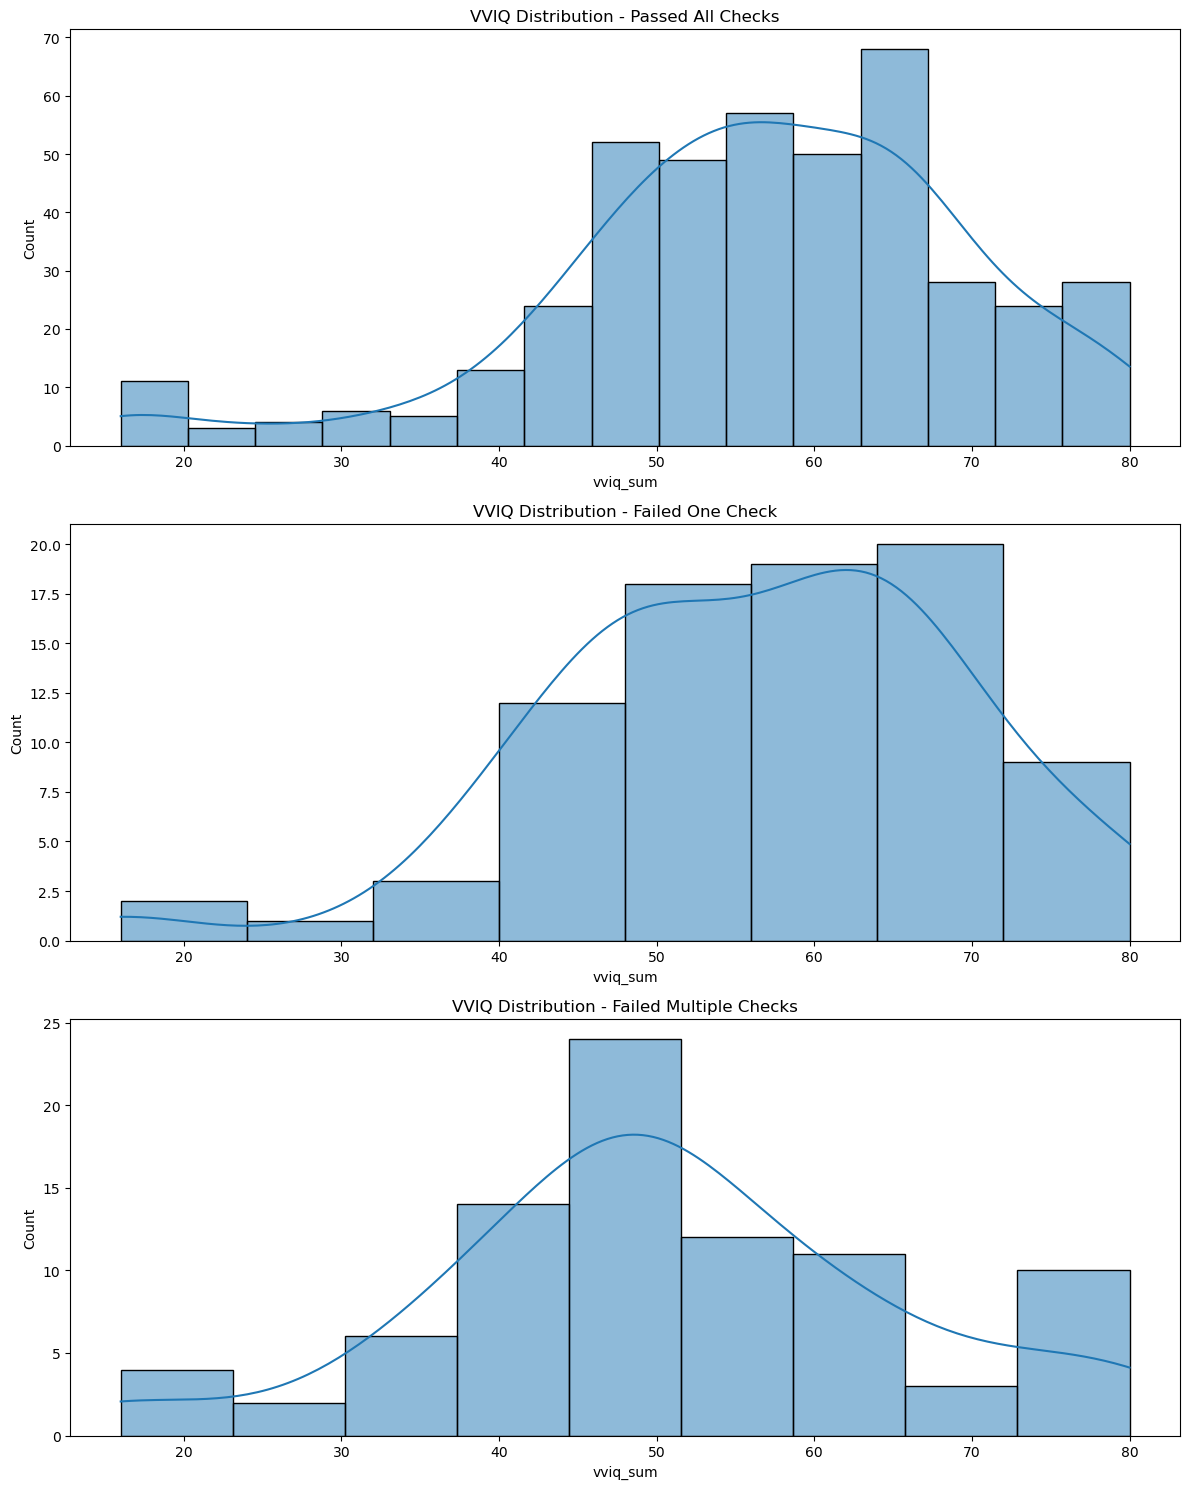

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create separate dataframes
df_pass_all = df_questionnaires[df_questionnaires['failed_check_count'] == 0]
df_fail_one = df_questionnaires[df_questionnaires['failed_check_count'] == 1]
df_fail_multi = df_questionnaires[df_questionnaires['failed_check_count'] > 1]

# Set up visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot histograms for vviq_sum across the three groups
sns.histplot(df_pass_all['vviq_sum'], kde=True, ax=axes[0])
axes[0].set_title('VVIQ Distribution - Passed All Checks')

sns.histplot(df_fail_one['vviq_sum'], kde=True, ax=axes[1])
axes[1].set_title('VVIQ Distribution - Failed One Check')

sns.histplot(df_fail_multi['vviq_sum'], kde=True, ax=axes[2])
axes[2].set_title('VVIQ Distribution - Failed Multiple Checks')

plt.tight_layout()
plt.show()

In [149]:
df_questionnaires

,subject_id,irq-catch-1,irq-manipulation-1,irq-manipulation-2,irq-manipulation-3,irq-manipulation-4,irq-manipulation-5,irq-manipulation-6,irq-manipulation-7,irq-manipulation-8,...,osivq_visual_mean,osivq_spatial_mean,irq_verbal_mean,irq_visual_mean,z_osivq_verbal_mean,z_osivq_visual_mean,z_osivq_spatial_mean,z_irq_verbal_mean,z_irq_visual_mean,failed_check_count
0,85174,1,3,3,3,1,3,3,3,2,...,2.666667,2.933333,2.750000,2.9,0.272313,-0.946143,0.132862,-1.369943,-0.856266,0
1,111154,1,4,2,4,1,4,1,4,2,...,3.466667,3.066667,3.333333,2.9,0.419940,0.341235,0.381374,-0.453404,-0.856266,0
2,111754,1,3,3,3,3,4,3,3,3,...,2.733333,3.000000,3.000000,3.0,-0.022942,-0.838862,0.257118,-0.977141,-0.708436,1
3,114154,4,4,4,4,3,2,4,3,4,...,2.333333,2.800000,3.583333,3.4,-0.465825,-1.482551,-0.115651,-0.060601,-0.117115,2
4,114541,1,2,4,4,4,2,2,3,5,...,2.800000,3.600000,4.083333,3.6,-1.646845,-0.731580,1.375424,0.725004,0.178545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,170536,1,2,2,2,1,5,2,3,2,...,2.266667,3.200000,3.333333,2.2,-0.170570,-1.589833,0.629887,-0.453404,-1.891076,0
588,170665,1,2,3,1,4,3,2,2,4,...,3.266667,2.400000,3.666667,3.5,0.715195,0.019390,-0.861188,0.070333,0.030715,0
589,171031,1,1,1,1,1,5,1,1,2,...,3.200000,2.533333,2.083333,2.4,-0.170570,-0.087891,-0.612676,-2.417417,-1.595416,1
590,171253,1,3,3,4,4,1,3,3,4,...,3.466667,3.000000,3.750000,3.6,0.715195,0.341235,0.257118,0.201267,0.178545,1


In [ ]:
# Elephants are larger than dogs. Is the most frequently failed check.

In [ ]:
# Save preprocessed dataframe
# df_questionnaires.to_csv('wm_questionnaires_preprocessed.csv')

In [150]:
# Save preprocessed dataframe with the column showing how many attention checks they failed
df_questionnaires.to_csv('wm_questionnaires_preprocessed.csv')